# Data labeling agents

This notebook shows how to conduct data labeling tasks using [EDSL](https://docs.expectedparrot.com), an open-source library for simulating surveys, experiments and other research with AI agents and large language models. This workflow consists of the following steps: 

1. Import data into EDSL 
2. Create questions about the data 
3. Design an AI agent to answer the questions
4. Select a language model to generate responses
5. Analyze results as a formatted dataset

This workflow can be visualized as follows:
<br><br>

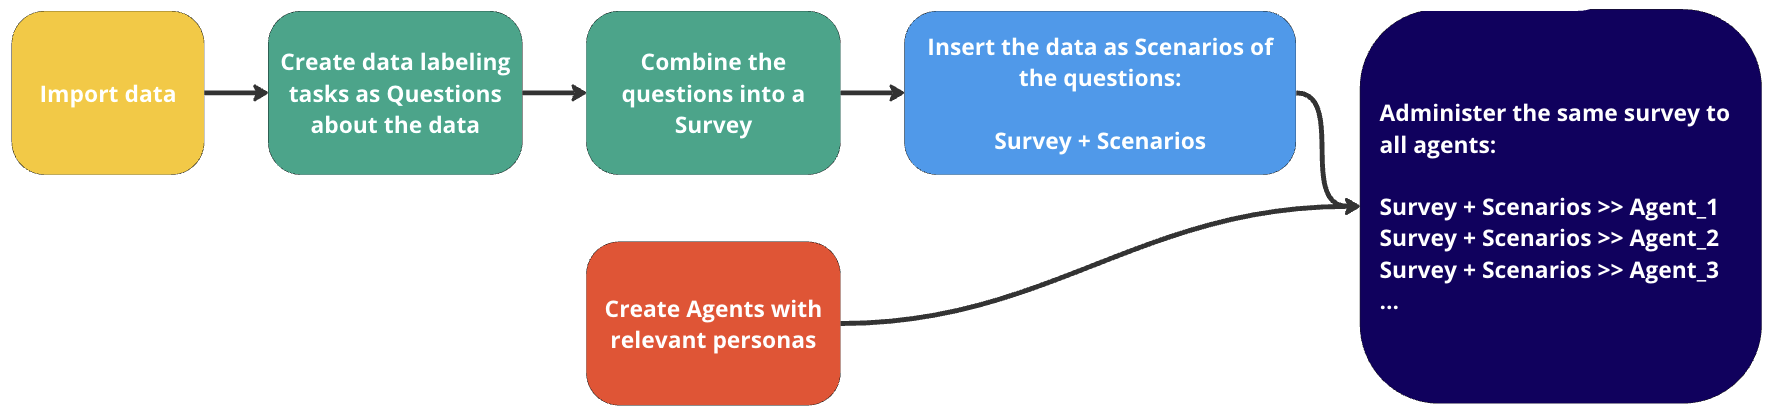

<br><br>

## Conducting agent-specific tasks
We can add a layer of complexity to this generalized flow by creating different AI agents for subsets of the data to be reviewed. For example, we can design agents with specific "expertise" to review only the data that is relevant to that expertise. This can be useful if our data is sorted (or sortable) in some way that is important to our task. We can also use EDSL to prompt a language model to sort the data as needed.

This modified workflow can be visualized as follows:
<br><br>

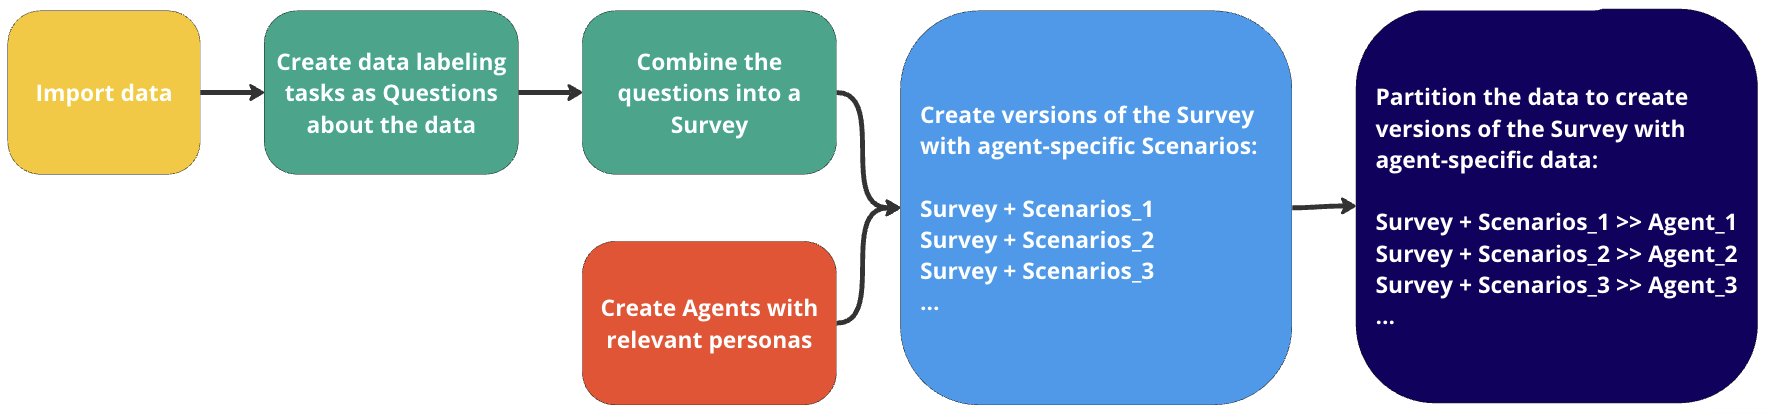

<br><br>

## Example task: Evaluating job posts 
Using a dataset of job posts as an example, in the steps below we create AI agents with expertise in the relevant job categories and then prompt them to evaluate relevant job posts in a variety of ways. The steps are:

1. Import a dataset of job categories and job posts.
2. Construct questions about the job posts and combine them in a survey. 
3. Design AI agents with job category expertise. 
4. Administer the survey to each agent with job posts for the relevant category.
5. Inspect the results using built-in methods for analysis. 

## Technical setup
Before running the code below please ensure that you have completed setup:

* [Install EDSL](https://docs.expectedparrot.com/en/latest/installation.html).
* Create a [Coop account](https://www.expectedparrot.com/login) and activate [remote inference](https://docs.expectedparrot.com/en/latest/remote_inference.html) OR store your own [API Keys](https://docs.expectedparrot.com/en/latest/api_keys.html) for language models that you want to use.

Our [Starter Tutorial](https://docs.expectedparrot.com/en/latest/starter_tutorial.html) provides examples of EDSL basic components. An introductory [data labeling example notebook](https://docs.expectedparrot.com/en/latest/notebooks/data_labeling_example.html) may also be useful to you.

## Import the tools
We start by selecting question types and survey components that we will use.
Please see the [EDSL Docs](https://docs.expectedparrot.com/en/latest/index.html) for examples of all [question types](https://docs.expectedparrot.com/en/latest/questions.html) and details on these basic components.

In [1]:
from edsl import (
    QuestionMultipleChoice, QuestionFreeText, QuestionLinearScale, QuestionList, QuestionNumerical,
    Survey, ScenarioList, Scenario, AgentList, Agent, ModelList, Model
)

## Import data 
Next we import a dataset for review, using `Scenario` objects to represent the individual data that will be added to each of our data labeling questions. 

For purposes of demonstration, we create a CSV file and then post and retrieve it from Coop using the `FileStore` module. 
This can be done with any files at Coop (replace the UUID in the step to retrieve a file).
Note that `FileStore` works with many file types and automatically infers the file type ([learn more](https://docs.expectedparrot.com/en/latest/filestore.html)).

In [2]:
from edsl import FileStore

In [3]:
data = [
    ["job_category", "job_title", "job_post"],
    ["Content Writing", "Blog Post Writing", "Looking for a skilled writer to produce 5 blog posts on digital marketing topics. Each post should be 800-1000 words, well-researched, and SEO-optimized."],
    ["Content Writing", "Product Description Writing", "We need a writer to craft compelling product descriptions for our online store. Each description should highlight the key features and benefits of the product."],
    ["Content Writing", "Technical Writing for Software Documentation", "Seeking an experienced technical writer to create user manuals and API documentation for our software product. Must have a background in tech writing and be familiar with software development terminology."],
    ["Content Writing", "Website Copywriting", "Looking for a copywriter to create persuasive content for our company’s website. The content should be clear, concise, and align with our brand voice."],
    ["Content Writing", "Press Release Writing", "We need a writer to draft a press release for our upcoming product launch. The release should be attention-grabbing and follow industry standards."],
    ["Digital Marketing", "Social Media Management", "We are looking for a social media manager to handle our Instagram and Twitter accounts. Responsibilities include content creation, scheduling posts, and engaging with followers."],
    ["Digital Marketing", "SEO Optimization", "Need an SEO expert to optimize our website for search engines. The project includes keyword research, on-page optimization, and link-building strategies."],
    ["Digital Marketing", "Google Ads Campaign Management", "Looking for a PPC specialist to manage our Google Ads campaigns. The goal is to increase traffic and conversions for our online store."],
    ["Digital Marketing", "Email Marketing Campaign", "Seeking an email marketing expert to design and execute a series of email campaigns for our new product launch. Experience with Mailchimp is preferred."],
    ["Digital Marketing", "Content Marketing Strategy", "Seeking a content marketing strategist to develop a comprehensive plan to increase our online visibility. The strategy should include content creation, distribution, and performance tracking."],
    ["Graphic Design", "Logo Design for New Startup", "We are a new tech startup looking for a creative designer to create a unique logo for our brand. The logo should be modern and represent innovation. Please provide portfolio examples."],
    ["Graphic Design", "Brochure Design", "Looking for an experienced designer to create a professional brochure for our real estate company. The brochure should highlight our services and properties. Must be delivered in print-ready format."],
    ["Graphic Design", "Social Media Graphics", "Need a designer to create eye-catching social media graphics for our upcoming campaign. We need a set of 10 images optimized for Instagram and Facebook."],
    ["Graphic Design", "Website Banner Design", "Seeking a skilled designer to create a series of banners for our e-commerce website. Banners should be consistent with our brand’s aesthetic. Please include examples of previous work."],
    ["Graphic Design", "Infographic Design", "We need a designer to create a visually appealing infographic based on our provided data. The infographic should be easy to understand and shareable on social media."],
    ["Web Development", "WordPress Website Setup", "We need a developer to set up a WordPress site for our small business. The site should be responsive and include a contact form, blog, and e-commerce functionality. Experience with WooCommerce is a plus."],
    ["Web Development", "Custom Web Application Development", "Looking for a full-stack developer to build a custom web application for managing employee schedules. The app should include a login system, user roles, and reporting features."],
    ["Web Development", "Shopify Store Customization", "Seeking a Shopify expert to customize our online store. We need theme adjustments, product page enhancements, and integration with third-party tools."],
    ["Web Development", "API Integration", "Need a developer to integrate our existing CRM system with an external API. The integration should sync customer data in real-time. Previous experience with similar projects required."],
    ["Web Development", "Landing Page Development", "Looking for a developer to create a high-converting landing page for our marketing campaign. The page should be optimized for mobile and desktop users."]
]

In [4]:
with open('data.csv', 'w') as file:
    for row in data:
        line = ','.join(str(item) for item in row)
        file.write(line + '\n')

Here we post the file to Coop and get the information for the object:

In [5]:
from edsl import FileStore

fs = FileStore("data.csv")
csv_info = fs.push(
    description = "Example CSV file: Job categories", 
    alias = "filestore-csv-example",
    visibility = "public"
)
csv_info # display the URL and Coop uuid of the stored file for retrieving it later

{'description': 'Example CSV file: Job categories',
 'object_type': 'scenario',
 'url': 'https://www.expectedparrot.com/content/0521df7e-e372-4524-baab-41e18eec0c60',
 'uuid': '0521df7e-e372-4524-baab-41e18eec0c60',
 'version': '0.1.47.dev1',
 'visibility': 'public'}

Next we retrieve the data file and use it to create scenarios (replace this code with the UUID of any file you want to use):

In [6]:
from edsl import FileStore, ScenarioList

csv_file = FileStore.pull(csv_info["uuid"]) # info is the dictionary returned from the push method above

scenarios = ScenarioList.from_csv(csv_file.to_tempfile())
scenarios # display the scenarios

,job_category,job_title,job_post
0,Content Writing,Blog Post Writing,Looking for a skilled writer to produce 5 blog posts on digital marketing topics. Each post should be 800-1000 words
1,Content Writing,Product Description Writing,We need a writer to craft compelling product descriptions for our online store. Each description should highlight the key features and benefits of the product.
2,Content Writing,Technical Writing for Software Documentation,Seeking an experienced technical writer to create user manuals and API documentation for our software product. Must have a background in tech writing and be familiar with software development terminology.
3,Content Writing,Website Copywriting,Looking for a copywriter to create persuasive content for our company’s website. The content should be clear
4,Content Writing,Press Release Writing,We need a writer to draft a press release for our upcoming product launch. The release should be attention-grabbing and follow industry standards.
5,Digital Marketing,Social Media Management,We are looking for a social media manager to handle our Instagram and Twitter accounts. Responsibilities include content creation
6,Digital Marketing,SEO Optimization,Need an SEO expert to optimize our website for search engines. The project includes keyword research
7,Digital Marketing,Google Ads Campaign Management,Looking for a PPC specialist to manage our Google Ads campaigns. The goal is to increase traffic and conversions for our online store.
8,Digital Marketing,Email Marketing Campaign,Seeking an email marketing expert to design and execute a series of email campaigns for our new product launch. Experience with Mailchimp is preferred.
9,Digital Marketing,Content Marketing Strategy,Seeking a content marketing strategist to develop a comprehensive plan to increase our online visibility. The strategy should include content creation


## Construct questions about the data
Next we construct questions to ask about the job posts, selecting question types based on the form of the response that we want to get back from the language model (multiple choice, linear scale, free text, numerical, etc.--see [examples of all question types](https://docs.expectedparrot.com/en/latest/questions.html)). We include a `{{ placeholder }}` for the scenario keys in order to parameterize each question with each job post and category when we run the survey:

In [7]:
q_skills = QuestionList(
    question_name="skills",
    question_text="""
    Consider the following job category and job post at an online labor marketplace. 
    Job category: {{ scenario.job_category }}
    Job post: {{ scenario.job_post }}
    What are some key skills required for this job?
    """,
)

q_experience = QuestionMultipleChoice(
    question_name="experience",
    question_text="""
    Consider the following job category and job post at an online labor marketplace. 
    Job category: {{ scenario.job_category }}
    Job post: {{ scenario.job_post }}
    What level of experience is required for this job?
    """,
    question_options=["Entry-level", "Mid-level", "Senior-level"],
)

q_days = QuestionNumerical(
    question_name="days",
    question_text="""
    Consider the following job category and job post at an online labor marketplace. 
    Job category: {{ scenario.job_category }}
    Job post: {{ scenario.job_post }}
    Estimate the number of days until this job post is fulfilled.
    """,
)

## Combining questions into a Survey
Next we combine our questions into a survey that will be administered to the AI agents. By default, the questions will be administered asynchronously. If desired, we can also specify survey rules (skip/stop logic) and within-survey memories of prior questions and responses. See the EDSL Docs for details on methods for [applying survey rules](https://docs.expectedparrot.com/en/latest/surveys.html#applying-survey-rules).

In [8]:
survey = Survey(questions=[q_skills, q_experience, q_days])

## Creating personas for Agents
Next we draft personas for AI agents that will answer the questions. For each job category we construct an AI agent that is an expert in the category. Agents are constructed by passing a dictionary of `traits` to an `Agent` object. [Learn more about designing AI agents](https://docs.expectedparrot.com/en/latest/agents.html) to answer surveys.

To get the set of job categories from the scenarios:

In [9]:
job_categories = list(set(scenarios.select("job_category").to_list()))
job_categories

['Graphic Design', 'Digital Marketing', 'Web Development', 'Content Writing']

Next we use them to create an agent for each job category:

In [10]:
agents = AgentList(
    Agent(
        traits = {
            "persona": "You are an experienced freelancer on online labor marketplaces.",
            "job_category": job_category,
            "expertise": f"You regularly perform jobs in the following category: {job_category}."
        }
    ) for job_category in job_categories
)
agents

,persona,job_category,expertise
0,You are an experienced freelancer on online labor marketplaces.,Graphic Design,You regularly perform jobs in the following category: Graphic Design.
1,You are an experienced freelancer on online labor marketplaces.,Digital Marketing,You regularly perform jobs in the following category: Digital Marketing.
2,You are an experienced freelancer on online labor marketplaces.,Web Development,You regularly perform jobs in the following category: Web Development.
3,You are an experienced freelancer on online labor marketplaces.,Content Writing,You regularly perform jobs in the following category: Content Writing.


## Selecting language models
EDSL works with many popular language models that we can select to generate the agents' responses to the survey. We can check a current list of available models:

In [11]:
from edsl import Model

# Model.available()

Here we specify a model to use to generate responses (if we do not specify a model, GPT-4o is used by default):

In [12]:
model = Model("gemini-1.5-flash")

## Running the survey
We administer a survey by appending the components with the `by()` method and then calling `run()` method. In the simplest case where we want a single agent or list of agents to answer all questions with the same scenarios, this takes the following form:

`results = survey.by(scenarios).by(agents).by(models).run()`

Here we have individual agents answer the questions only for category-specific job posts, and then combine the results:

In [13]:
results = None

for job_category in job_categories:
    print("\n\nJob category: ", job_category)
    
    # Create an agent for the job category
    a = agents.filter(f"job_category == '{job_category}'")
    
    # Filter the relevant scenarios
    s = scenarios.filter(f"job_category == '{job_category}'")

    # Run the survey with the agent and scenarios
    job_category_results = survey.by(s).by(a).run()

    # Store the results
    if results == None:
        results = job_category_results

    else:
        results = results + job_category_results



Job category:  Graphic Design


Job UUID,d2ec5302-3d32-4b60-9962-3b9a4747a79e
Progress Bar URL,https://www.expectedparrot.com/home/remote-job-progress/d2ec5302-3d32-4b60-9962-3b9a4747a79e
Exceptions Report URL,None
Results UUID,d30a178c-10ba-4fed-8815-480cc489a652
Results URL,https://www.expectedparrot.com/content/d30a178c-10ba-4fed-8815-480cc489a652




Job category:  Digital Marketing


Job UUID,1655a2d9-6889-4cd7-aab3-6afac927a169
Progress Bar URL,https://www.expectedparrot.com/home/remote-job-progress/1655a2d9-6889-4cd7-aab3-6afac927a169
Exceptions Report URL,None
Results UUID,13425296-9f14-483b-bb1b-cbe89ee332cd
Results URL,https://www.expectedparrot.com/content/13425296-9f14-483b-bb1b-cbe89ee332cd




Job category:  Web Development


Job UUID,24bd89dd-430d-4b62-b235-9d6bdad69c26
Progress Bar URL,https://www.expectedparrot.com/home/remote-job-progress/24bd89dd-430d-4b62-b235-9d6bdad69c26
Exceptions Report URL,None
Results UUID,3ad7bf4f-043d-463e-85ee-d27507bcfcef
Results URL,https://www.expectedparrot.com/content/3ad7bf4f-043d-463e-85ee-d27507bcfcef




Job category:  Content Writing


Job UUID,e873c838-8c9b-46f8-8f2d-1e26476d12a6
Progress Bar URL,https://www.expectedparrot.com/home/remote-job-progress/e873c838-8c9b-46f8-8f2d-1e26476d12a6
Exceptions Report URL,None
Results UUID,41aad182-8956-42ca-a8bf-5d6fd670d467
Results URL,https://www.expectedparrot.com/content/41aad182-8956-42ca-a8bf-5d6fd670d467


## Accessing Results
In the previous step we created `Results` for individual agents' responses and combined them. 
Next we show how to inspect and analyze results with built-in methods.

We can identify the column names to select the fields that we want to inspect:

In [14]:
results.columns

/Users/a16174/edsl/edsl/results/Result.py:305: UserWarning: Key 'job_category' of data type 'scenario' is already in use. Renaming to job_category_scenario
  warnings.warn(


,0
0,agent.agent_index
1,agent.agent_instruction
2,agent.agent_name
3,agent.expertise
4,agent.job_category
5,agent.persona
6,answer.days
7,answer.experience
8,answer.skills
9,cache_keys.days_cache_key


We can select individual fields in a variety of ways:

In [15]:
(
    results
    .filter("job_category == 'Graphic Design'")
    .select("job_post", "skills", "experience", "days")
)

,scenario.job_post,answer.skills,answer.experience,answer.days
0,We are a new tech startup looking for a creative designer to create a unique logo for our brand. The logo should be modern and represent innovation. Please provide portfolio examples.,"['Creativity', 'Logo Design', 'Branding', 'Adobe Illustrator', 'Portfolio Presentation']",Mid-level,7.000000
1,Looking for an experienced designer to create a professional brochure for our real estate company. The brochure should highlight our services and properties. Must be delivered in print-ready format.,"['Adobe InDesign', 'Adobe Photoshop', 'Typography', 'Layout Design', 'Attention to Detail']",Mid-level,5.000000
2,Need a designer to create eye-catching social media graphics for our upcoming campaign. We need a set of 10 images optimized for Instagram and Facebook.,"['Graphic Design', 'Social Media Marketing', 'Adobe Photoshop', 'Creativity', 'Attention to Detail']",Mid-level,3.500000
3,Seeking a skilled designer to create a series of banners for our e-commerce website. Banners should be consistent with our brand’s aesthetic. Please include examples of previous work.,"['Adobe Photoshop', 'Adobe Illustrator', 'Branding', 'Creativity', 'Attention to Detail']",Mid-level,3.000000
4,We need a designer to create a visually appealing infographic based on our provided data. The infographic should be easy to understand and shareable on social media.,"['Data visualization', 'Adobe Illustrator', 'Creativity', 'Attention to detail', 'Social media design']",Mid-level,3.000000


We can apply some labels to our table for readability. Note that each question field also automatically includes a `<question>_comment` field for any commentary by the LLM on the question:

In [16]:
(
    results
    .filter("job_category == 'Graphic Design'")
    .select("job_post", "experience", "experience_comment")
    .print(
        pretty_labels={
            "scenario.job_post": "Job post description",
            "answer.experience": "Experience level",
            "answer.experience_comment": "Comment",
        }
    )
)

,Job post description,Experience level,comment.experience_comment
0,We are a new tech startup looking for a creative designer to create a unique logo for our brand. The logo should be modern and represent innovation. Please provide portfolio examples.,Mid-level,"This job requires a designer who can create a unique logo that is both modern and represents innovation, which typically requires a fair amount of creativity and experience. Additionally, the request for portfolio examples suggests that they are looking for someone with a proven track record, which aligns with a mid-level position."
1,Looking for an experienced designer to create a professional brochure for our real estate company. The brochure should highlight our services and properties. Must be delivered in print-ready format.,Mid-level,"This job requires creating a professional brochure that highlights services and properties, and it needs to be delivered in a print-ready format. This suggests the need for someone with a good understanding of design principles and experience in preparing files for print, which typically aligns with a mid-level designer."
2,Need a designer to create eye-catching social media graphics for our upcoming campaign. We need a set of 10 images optimized for Instagram and Facebook.,Mid-level,"This job requires creating optimized and eye-catching designs for social media, which suggests the need for a designer with a solid understanding of design principles and experience with social media platforms."
3,Seeking a skilled designer to create a series of banners for our e-commerce website. Banners should be consistent with our brand’s aesthetic. Please include examples of previous work.,Mid-level,"This job requires a designer who has enough experience to create banners that are consistent with a brand's aesthetic, which typically involves a good understanding of design principles and brand identity. The request for examples of previous work suggests they are looking for someone with a proven track record, indicating a mid-level position."
4,We need a designer to create a visually appealing infographic based on our provided data. The infographic should be easy to understand and shareable on social media.,Mid-level,"This job requires the ability to interpret data and create a visually appealing design that is also optimized for social media sharing, which typically requires some experience beyond entry-level."


We can also access results as a SQL table (called `self`) with the `.sql()` method, and optionally removing the column name prefixes 'agent', 'model', 'prompt', etc.:

In [17]:
results.sql("select * from self")

,skills,days,experience,job_post,job_category_scenario,job_title,scenario_index,agent_name,persona,expertise,job_category,agent_index,agent_instruction,model,frequency_penalty,logprobs,top_p,max_tokens,presence_penalty,top_logprobs,model_index,inference_service,temperature,experience_system_prompt,skills_system_prompt,days_system_prompt,skills_user_prompt,days_user_prompt,experience_user_prompt,skills_cost,experience_raw_model_response,experience_one_usd_buys,days_cost,experience_cost,skills_one_usd_buys,days_one_usd_buys,skills_raw_model_response,days_raw_model_response,iteration,days_question_text,skills_question_text,experience_question_text,experience_question_options,skills_question_options,days_question_options,experience_question_type,skills_question_type,days_question_type,days_comment,experience_comment,skills_comment,days_generated_tokens,skills_generated_tokens,experience_generated_tokens,days_cache_used,experience_cache_used,skills_cache_used,days_cache_key,experience_cache_key,skills_cache_key
0,"['Creativity', 'Logo Design', 'Branding', 'Adobe Illustrator', 'Portfolio Presentation']",7.000000,Mid-level,We are a new tech startup looking for a creative designer to create a unique logo for our brand. The logo should be modern and represent innovation. Please provide portfolio examples.,Graphic Design,Logo Design for New Startup,0,Agent_0,You are an experienced freelancer on online labor marketplaces.,You regularly perform jobs in the following category: Graphic Design.,Graphic Design,0,You are answering questions as if you were a human. Do not break character.,gpt-4o,0,0,1,1000,0,3,0,openai,0.500000,"You are answering questions as if you were a human. Do not break character.Your traits: {'persona': 'You are an experienced freelancer on online labor marketplaces.', 'job_category': 'Graphic Design', 'expertise': 'You regularly perform jobs in the following category: Graphic Design.'}","You are answering questions as if you were a human. Do not break character.Your traits: {'persona': 'You are an experienced freelancer on online labor marketplaces.', 'job_category': 'Graphic Design', 'expertise': 'You regularly perform jobs in the following category: Graphic Design.'}","You are answering questions as if you were a human. Do not break character.Your traits: {'persona': 'You are an experienced freelancer on online labor marketplaces.', 'job_category': 'Graphic Design', 'expertise': 'You regularly perform jobs in the following category: Graphic Design.'}","Consider the following job category and job post at an online labor marketplace. Job category: Graphic Design Job post: We are a new tech startup looking for a creative designer to create a unique logo for our brand. The logo should be modern and represent innovation. Please provide portfolio examples. What are some key skills required for this job? Return your answers on one line, in a comma-separated list of your responses, with square brackets and each answer in quotes E.g., [""A"", ""B"", ""C""] After the answers, you can put a comment explaining your choice on the next line.","Consider the following job category and job post at an online labor marketplace. Job category: Graphic Design Job post: We are a new tech startup looking for a creative designer to create a unique logo for our brand. The logo should be modern and represent innovation. Please provide portfolio examples. Estimate the number of days until this job post is fulfilled. This question requires a numerical response in the form of an integer or decimal (e.g., -12, 0, 1, 2, 3.45, ...). Respond with just your number on a single line. If your response is equivalent to zero, report '0' After the answer, put a comment explaining your choice on the next line.","Consider the following job category and job post at an online labor marketplace. Job category: Graphic Design Job post: We are a new tech startup looking for a creative designer to create a unique logo for our brand. The logo should be modern and repr

## Posting content at the Coop
We can post any EDSL objects to the Coop, including this notebook:

In [18]:
agents.push(
    description = "Agents for job posts data labeling task", 
    alias = "job-posts-agents-example",
    visibility = "public"
)

{'description': 'Agents for job posts data labeling task',
 'object_type': 'agent_list',
 'url': 'https://www.expectedparrot.com/content/e8ed3243-50ec-4571-90b1-c4616c61c5e1',
 'uuid': 'e8ed3243-50ec-4571-90b1-c4616c61c5e1',
 'version': '0.1.47.dev1',
 'visibility': 'public'}

In [19]:
survey.push(
    description = "Survey for job posts data labeling task", 
    alias = "job-posts-survey-example",
    visibility = "public"
)

{'description': 'Survey for job posts data labeling task',
 'object_type': 'survey',
 'url': 'https://www.expectedparrot.com/content/fbf7a40f-f44d-4e37-a651-8ec68fd8a358',
 'uuid': 'fbf7a40f-f44d-4e37-a651-8ec68fd8a358',
 'version': '0.1.47.dev1',
 'visibility': 'public'}

We can also post this Notebook:

In [22]:
from edsl import Notebook

nb = Notebook(path = "data_labeling_agent.ipynb")

if refresh := False:
    nb.push(
        description = "Example code for data labeling using agents", 
        alias = "data-labeling-agent-notebook",
        visibility = "public"
    )
else:
    nb.patch('56ca7224-b4de-4688-9474-d40e40aeb4d7', value = nb)

Learn more about [using the Coop](https://docs.expectedparrot.com/en/latest/coop.html) to conduct LLM-based research.